# CNN Water Transport Classification
## Deep Learning Convolutional Neural Network
## AI & ML Project Part B

**Objective:**  
The objective of this project is to develop a deep learning–based image classification system capable of accurately identifying different types of water transport vessels. The model classifies input images into one of five categories: cruise ship, submarine, boat, hovercraft, or cargo ship.

**Models Used:**  
- Keras (TensorFlow)

**Web Server Prediction:**  
A local web application was developed to demonstrate the model’s deployment and prediction capability:
- Flask-based localhost web server
- Users can upload an image and receive:
     - The predicted vessel class
     - Confidence scores for all classes

In [1]:
import warnings 
warnings.simplefilter(action='ignore')

In [2]:
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib
from tensorflow.keras import datasets, layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras import optimizers

## 1. Training Dataset Augmentation (5× Expansion)

This code generates five augmented versions of each training image using Keras’ ImageDataGenerator. The augmented images are saved to disk and organised by class, effectively expanding the training dataset and improving model robustness.

In [4]:
src_dir = "images/train"          
out_dir = "dataset/train_aug5x"    
n_aug = 5                         
img_size = (224, 224)             


aug = ImageDataGenerator(
    rescale=1./255,   
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,      
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

os.makedirs(out_dir, exist_ok=True)

for class_name in os.listdir(src_dir):
    class_path = os.path.join(src_dir, class_name)
    if not os.path.isdir(class_path):
        continue
    out_class_path = os.path.join(out_dir, class_name)
    os.makedirs(out_class_path, exist_ok=True)
    for fname in os.listdir(class_path):
        if not fname.lower().endswith((".png", ".jpg", ".jpeg", ".bmp")):
            continue
        img_path = os.path.join(class_path, fname)
        img = load_img(img_path, target_size=img_size)
        x = img_to_array(img)               
        x = np.expand_dims(x, axis=0)          
        base = os.path.splitext(fname)[0]
        tf.keras.utils.save_img(
            os.path.join(out_class_path, f"{base}_orig.jpg"),
            img_to_array(img)
        )
        i = 0
        for batch in aug.flow(x, batch_size=1):
            tf.keras.utils.save_img(
                os.path.join(out_class_path, f"{base}_aug{i+1}.jpg"),
                batch[0]
            )
            i += 1
            if i >= n_aug:
                break
print("Done! Augmented dataset saved to:", out_dir)

Done! Augmented dataset saved to: dataset/train_aug5x


### Display of total images from "dataset/train_aug5x"

In [5]:
total_images = 0

for class_name in os.listdir("./dataset/train_aug5x"):
    class_path = os.path.join("./dataset/train_aug5x", class_name)
    if os.path.isdir(class_path):
        num_images = len([
            f for f in os.listdir(class_path)
            if f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ])
        total_images += num_images
        print(f"{class_name}: {num_images} images")

print("Total images:", total_images)

boat_train: 876 images
cargoship_train: 792 images
cruiseship_train: 870 images
hovercraft_train: 834 images
submarine_train: 804 images
Total images: 4176


## 2. Choosing batch size

**Why I chose batch size of 32:**  
A batch size of 32 was chosen as it provides a good balance between training stability, learning efficiency, and memory usage. Compared to smaller batch sizes, a batch size of 32 reduces gradient noise while still allowing sufficiently frequent weight updates during training.

Using a larger batch size such as 64 would reduce the number of updates per epoch to approximately 66, which may slow the learning process and reduce the model’s ability to generalise. Conversely, very small batch sizes can result in noisier gradients and longer training times. Therefore, a batch size of 32 represents a suitable compromise for effective and stable model training.

**With a total of 4,176 training images, this results in:   
4,176 ÷ 32 = 130.5, which is rounded up to 131 batches per epoch.**

In [6]:
img_height, img_width = 224, 224
batch_size = 32

## 3. Training and Validation Data Preparation
The augmented training dataset is rescaled and divided into training and validation sets using ImageDataGenerator. This ensures consistent preprocessing and allows model performance to be evaluated on unseen validation data.

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

**Why did I include validation_split = 0.2:**  
The dataset is split into 80% training data and 20% validation data. The validation set is used to evaluate the model’s performance on unseen data during training, allowing us to determine whether the model is learning meaningful patterns or simply memorising the training data.     
**Including a validation set can help us detect overfitting and for selecting and tuning hyperparameters to improve model performance.**

In [5]:
train_generator = train_datagen.flow_from_directory(
    "./dataset/train_aug5x",
    target_size=(img_height,img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset="training",
    shuffle=True
)

Found 3343 images belonging to 5 classes.


**Why did I chose class_mode='categorical':**  
I chose categorical because my problem involves five classes and the output layer uses a softmax activation function. Using categorical class mode means the labels are one-hot encoded, for example [0, 0, 1, 0, 0].   
I did not chose sparse as I prefer categorical encoding, as it explicitly represents each class, which is easier to explain and visualise.   
**Why do we need to shuffle train data:**  
Shuffling will prevents the model from memorising the order of the data.

In [6]:
validation_generator = train_datagen.flow_from_directory(
    "./dataset/train_aug5x",
    target_size=(img_height,img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset="validation",
    shuffle=False #True
)

Found 833 images belonging to 5 classes.


### Display the tensor shape and image from ImageGenerator output

Tensor shape with batch 32:  (32, 224, 224, 3)


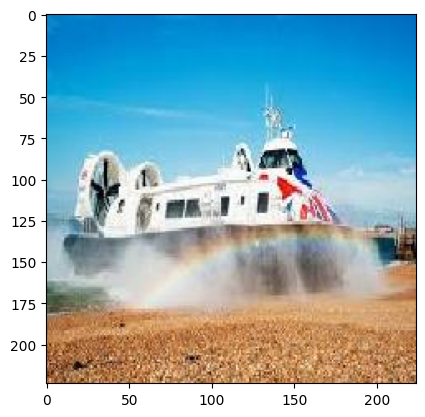

In [7]:
print("Tensor shape with batch 32: ", train_generator[0][0].shape)
image = train_generator[0][0][0]
plt.imshow(image)

## 4. Model Architecture
**2D Convolution is use to capture features like:**
- horizontal edges
- vertical edges
- diagonal edges
- corners
- curves
- texture patterns

**How I choose filters:**  
The first convolution layer uses 16 filters, allowing the network to learn 16 different feature patterns in parallel. As the network becomes deeper, the number of filters is increased (32 and 64) to enable the extraction of more complex and abstract features. This progressive increase helps the model capture both low-level and high-level visual information effectively.

**Kernel size (5x5):**  
The kernel size (5,5) refers to a 5×5 convolution window that slides across the image. A larger kernel allows the model to capture broader spatial context and larger patterns in the image, which is suitable for recognising object shapes in this classification task.

**Why did I use MaxPooling2D:**  
MaxPooling2D is applied after each convolution layer to reduce the spatial dimensions of the feature maps while retaining the most important activations. This reduces computational cost, controls overfitting, and helps the model focus on the most salient features. Max pooling performs a fixed downsampling operation and does not introduce additional trainable parameters.

**Why did I not use stride for faster training:**  
Since the architecture consists of a relatively small number of convolution layers, MaxPooling2D provides sufficient and controlled spatial reduction. Keeping the stride at its default value of 1 also helps preserve spatial details in the early layers, which is beneficial for feature extraction in a shallow CNN.

**Why did I use padding='same' instead of padding='valid':**  
Padding is set to "same" so that the kernel can also capture features at the edges and corners of the image while preserving the original spatial dimensions of the feature maps. Using "valid" padding would shrink the feature map size and reduce the contribution of edge pixels, which is not desirable in the early layers of a shallow layers.

**ReLu:**  
ReLU is used in the hidden layers because it allow the model to learn complex patterns. It also helps reduce gradient problems and enables faster and more efficient training by setting negative activations to zero.

**Softmax:**  
Softmax is used in the output layer because the task is a multi-class classification problem with 5 classes. It converts the output values into probabilities that sum to one, allowing the model to predict the most likely class.

In [8]:
classes = 5
model = tf.keras.Sequential([
    tf.keras.Input(shape=(224,224,3)),
    layers.Conv2D(16, (3,3), padding="same", activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32, (3,3), padding="same", activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), padding="same", activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), padding="same", activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(256, (3,3), padding="same", activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4),
    # layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(classes, activation="softmax")
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 14, 14, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 426,149 (1.63 MB)

 Trainable params: 426,149 (1.63 MB)

 Non-trainable params: 0 (0.00 B)

## 5. Compile and Train model
**Adam:**
- Controls learning rate
- Balances speed and stability

**Categorical_crossentropy:**  
Categorical cross-entropy is used because the labels are one-hot encoded (class_mode="categorical") and the output layer uses a softmax activation function.  
It will show how wrong my model's prediction are. If it is lower = better prediction

In [9]:
model.compile(
    optimizer="adam", 
    loss="categorical_crossentropy", 
    metrics=['accuracy']
)

**Why I use early_stop:**  
The training will stop early when the patience value was set to 6, and the validation loss continued to improve intermittently. The lowest validation loss occurred at Epoch X, indicating the best generalisation performance among all epochs. Therefore, the model from Epoch X will be selected as the optimal model.

**Patience:**  
After the lowest monitor value, how many times it will continue to wait till it trigger early_stop

In [10]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=10,
    restore_best_weights=True
)

In [11]:
history = model.fit(train_generator, validation_data=validation_generator, epochs=50, callbacks=[early_stop], verbose=1)

Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 19s 167ms/step - accuracy: 0.2821 - loss: 1.5577 - val_accuracy: 0.3241 - val_loss: 1.5499
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 18s 172ms/step - accuracy: 0.3419 - loss: 1.4338 - val_accuracy: 0.4142 - val_loss: 1.3468
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 18s 173ms/step - accuracy: 0.4224 - loss: 1.3030 - val_accuracy: 0.4070 - val_loss: 1.3673
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 18s 173ms/step - accuracy: 0.4993 - loss: 1.1783 - val_accuracy: 0.3709 - val_loss: 1.5692
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 18s 175ms/step - accuracy: 0.5648 - loss: 1.0651 - val_accuracy: 0.5378 - val_loss: 1.4183
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 19s 178ms/step - accuracy: 0.6186 - loss: 0.9579 - val_accuracy: 0.5882 - val_loss: 1.3424
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 18s 176ms/step - accuracy: 0.6997 - loss: 0.7760 - val_accuracy: 0.5894 - val_loss: 1.4177
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 18s 176ms/step - accuracy: 0.7350 - loss: 0

In [12]:
model.save("./models/watertransport_model.keras") 
print("Saved model")

Saved model


### Custom CNN Model 
Validation Accuracy: 70.59%   
Training Accuracy: 99.85%

## 6. Test accuracy of model

In [14]:
val_loss, val_acc = model.evaluate(validation_generator, verbose=0)
train_loss, train_acc = model.evaluate(train_generator, verbose=0)

print(f"Validation Accuracy: {val_acc*100:.2f}%")
print(f"Training Accuracy: {train_acc*100:.2f}%")

Validation Accuracy: 70.59%
Training Accuracy: 99.85%


In [30]:
test_generator = test_datagen.flow_from_directory(
    "./images/test",
    target_size=(224,224),
    batch_size=16,
    class_mode="categorical",
    shuffle=True
)

Found 141 images belonging to 5 classes.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


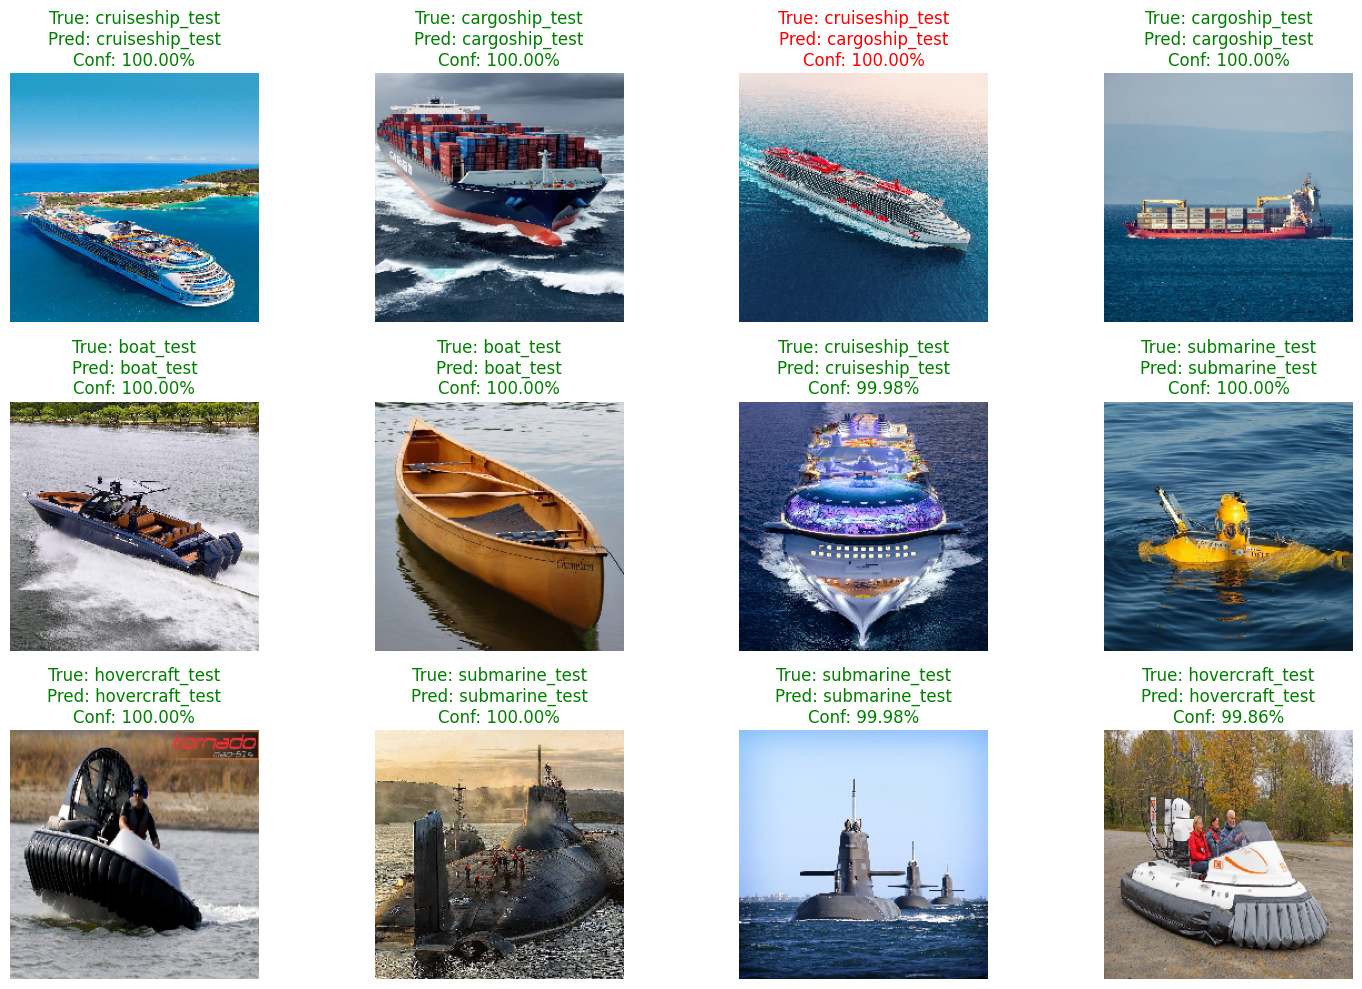

In [31]:
# Get one batch from TEST set
images, labels = next(test_generator)

# Predict
predictions = model.predict(images)

# Convert one-hot to class index
true_classes = np.argmax(labels, axis=1)
pred_classes = np.argmax(predictions, axis=1)

class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(15,10))

for i in range(min(12, len(images))):
    plt.subplot(3,4,i+1)
    img_show = images[i]
    img_show = (img_show - img_show.min()) / (img_show.max() - img_show.min() + 1e-8)

    plt.imshow(img_show)
    plt.axis("off")

    true_label = class_names[true_classes[i]]
    pred_label = class_names[pred_classes[i]]
    confidence = np.max(predictions[i]) * 100

    color = "green" if true_label == pred_label else "red"

    plt.title(
        f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}%",
        color=color
    )

plt.tight_layout()
plt.show()

## ResNet50 Pretrained Model – Data Augmentation and Preprocessing
After evaluating the performance of the custom CNN, a ResNet50 pretrained model was used to further improve classification accuracy by leveraging transfer learning and pre-learned feature representations.

## 1. Augmentation of images
Since offline augmentation had already increased the dataset size, additional real-time augmentation was not applied for the ResNet50 model.

In [7]:
train_datagen_resnet50 = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split = 0.2  
)

In [8]:
train_generator_resnet50 = train_datagen_resnet50.flow_from_directory(
    "./dataset/train_aug5x",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",   
    subset="training",
    shuffle=True
)

Found 3343 images belonging to 5 classes.


### Displaying of augmented images

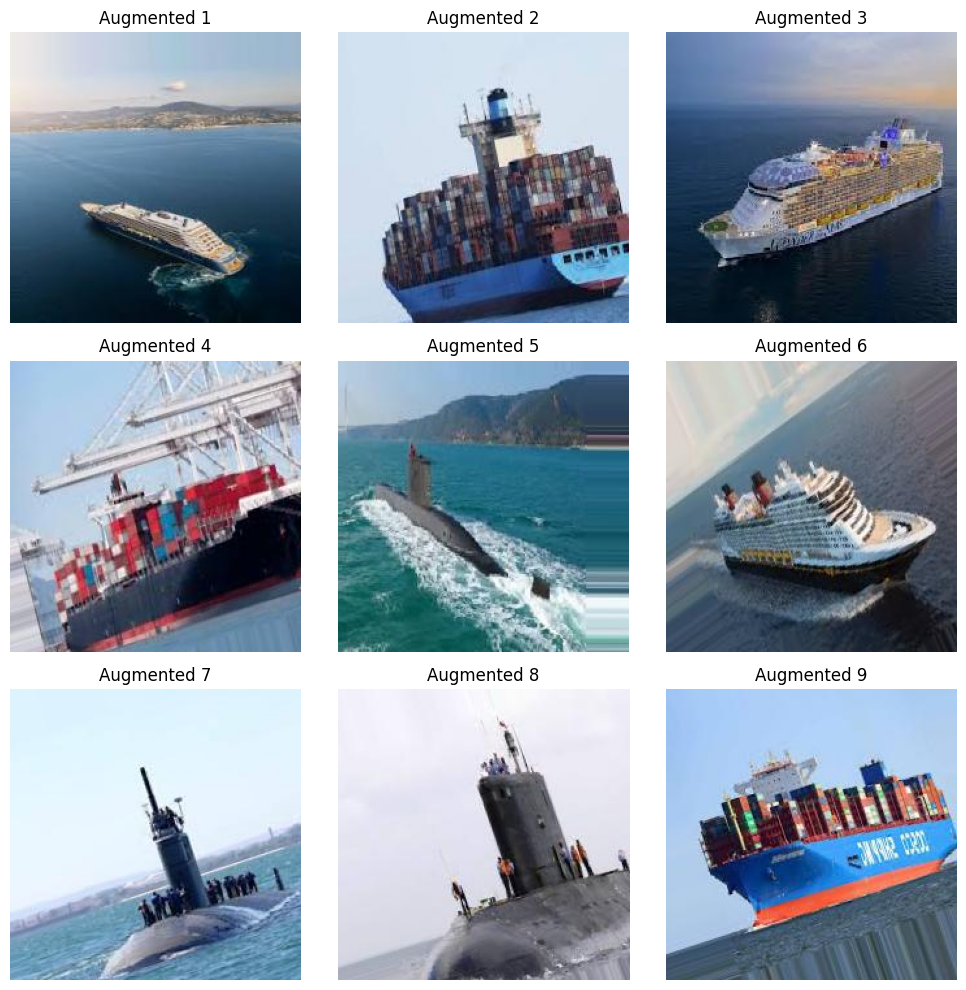

Found 833 images belonging to 5 classes.


In [9]:
aug_images, _ = next(train_generator_resnet50)
mean = [103.939, 116.779, 123.68]  # BGR means
plt.figure(figsize=(10, 10))
for i in range(9):
    img = aug_images[i].copy()
    img[..., 0] += mean[0]
    img[..., 1] += mean[1]
    img[..., 2] += mean[2]
    img = img[..., ::-1]   # BGR -> RGB
    img = img / 255.0
    img = img.clip(0, 1)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(f"Augmented {i+1}")
    plt.axis("off")
plt.tight_layout()
plt.show()

validation_generator_resnet50 = train_datagen_resnet50.flow_from_directory(
    "./dataset/train_aug5x",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

## 2. Model Architecture

**Base Model (ResNet50):**   
ResNet50 pretrained on the ImageNet dataset is used as the base model to leverage transfer learning for improved feature extraction and faster convergence. The top classification layers are removed so that ResNet50 functions as a feature extractor, while a custom classification head is trained for the water transport classes. All pretrained layers are frozen to preserve learned features and reduce overfitting during training.   
**ResNet50 contains over one million images across 1000 classes. This approach is known as transfer learning and allows faster convergence and improved generalization compared to training a CNN from scratch.**

In [10]:
base_model = ResNet50(
    input_shape=(img_height,img_width,3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

**Why did I use GlobalAveragePooling2D?**  
Global Average Pooling is used to reduce each feature map to a single value by averaging across spatial dimensions. This significantly reduces the number of parameters compared to flattening and helps improve generalization while retaining the most important global features.

In [11]:
num_classes = 5
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation="softmax")
])

## 3. Model Training

In [12]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,145,797 (92.11 MB)

 Trainable params: 558,085 (2.13 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [14]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history_phase1 = model.fit(
    train_generator_resnet50,
    validation_data=validation_generator_resnet50,
    epochs=20,
    callbacks=[early_stop]
)

Epoch 1/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.8232 - loss: 0.4876 - val_accuracy: 0.9172 - val_loss: 0.2794
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.9623 - loss: 0.1109 - val_accuracy: 0.9244 - val_loss: 0.2422
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.9788 - loss: 0.0682 - val_accuracy: 0.9316 - val_loss: 0.2814
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - accuracy: 0.9865 - loss: 0.0395 - val_accuracy: 0.9220 - val_loss: 0.4043
Epoch 5/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - accuracy: 0.9868 - loss: 0.0387 - val_accuracy: 0.9232 - val_loss: 0.3252
Epoch 6/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.9832 - loss: 0.0596 - val_accuracy: 0.9244 - val_loss: 0.2903
Epoch 7/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.9871 - loss: 0.0328 - val_accuracy: 0.9352 - val_loss: 0.3394


## 4. Fine-Tuning  
Fine-tuning was performed by unfreezing the last 30 layers of the ResNet50 base model to adapt high-level features to the water transport classification task. A low learning rate was used to update pretrained weights gradually, and early stopping was applied to prevent overfitting and restore the best model weights, resulting in improved validation performance and generalisation.

In [15]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

base_model.trainable = True
for layer in base_model.layers[:-30]:   # keep last 30 layers trainable
    layer.trainable = False

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_phase2 = model.fit(
    train_generator_resnet50,
    validation_data=validation_generator_resnet50,
    epochs=30,
    callbacks=[early_stop]
)

Epoch 1/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - accuracy: 0.9435 - loss: 0.1709 - val_accuracy: 0.9016 - val_loss: 0.3752
Epoch 2/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.9844 - loss: 0.0497 - val_accuracy: 0.9136 - val_loss: 0.3167
Epoch 3/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.9931 - loss: 0.0306 - val_accuracy: 0.9232 - val_loss: 0.3002
Epoch 4/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - accuracy: 0.9928 - loss: 0.0225 - val_accuracy: 0.9256 - val_loss: 0.3104
Epoch 5/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.9964 - loss: 0.0144 - val_accuracy: 0.9244 - val_loss: 0.3019
Epoch 6/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.9976 - loss: 0.0116 - val_accuracy: 0.9304 - val_loss: 0.2890
Epoch 7/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.9973 - loss: 0.0100 - val_accuracy: 0.9268 - val_loss: 0.3012
Epoch 8/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.9985 - loss: 0.0066 - val_accu

## 5. Saving the trained model

In [16]:
model.save("./models/my_resnet50_model.keras") #accuracy: 0.9940 - loss: 0.0181 - val_accuracy: 0.9268 - val_loss: 0.3140
val_loss, val_acc = model.evaluate(validation_generator_resnet50, verbose=0)
train_loss, train_acc = model.evaluate(train_generator_resnet50, verbose=0)

print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc*100:.2f}%")
print(f"Training Loss: {train_loss:.4f}")
print(f"Training Accuracy: {train_acc*100:.2f}%")

Validation Loss: 0.2884
Validation Accuracy: 93.16%
Training Loss: 0.0000
Training Accuracy: 100.00%


### ResNet50 Model  
Validation Accuracy: 93.16%  
Training Accuracy: 100.00%

## 6. Model Testing
The trained ResNet50 model was evaluated using a separate test dataset that was not used during training or validation. The test images were preprocessed using the same preprocess_input function to ensure consistency with the training pipeline.

With 141 test images across five classes, the model achieved a test accuracy of approximately 92.9% and a test loss of 0.49, demonstrating good generalisation and minimal overfitting.

In [18]:
test_datagen_resnet50 = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [19]:
test_generator_resnet50 = test_datagen_resnet50.flow_from_directory(
    "./images/test",
    target_size=(224, 224),
    batch_size=16,
    class_mode="categorical",
    shuffle=True  
)

Found 141 images belonging to 5 classes.


In [20]:
test_loss, test_accuracy = model.evaluate(test_generator_resnet50)

print("Test accuracy:", test_accuracy)
print("Test loss:", test_loss)

9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 909ms/step - accuracy: 0.9504 - loss: 0.2373
Test accuracy: 0.9503546357154846
Test loss: 0.23732233047485352


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


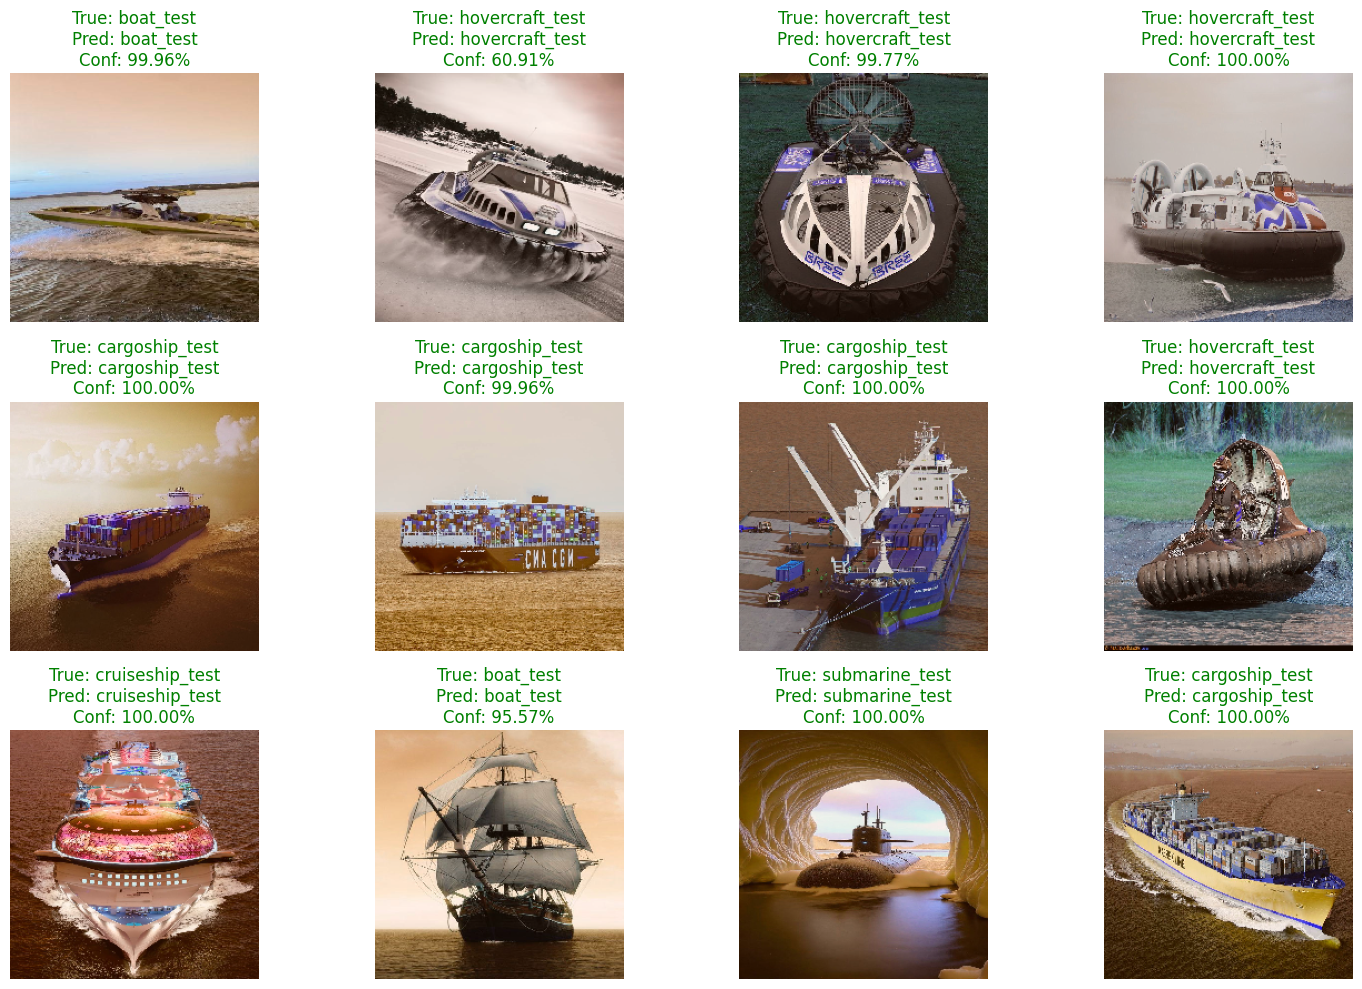

In [21]:
##### Get one batch from test set
images, labels = next(test_generator_resnet50)

# Predict
predictions = model.predict(images)

# Convert one-hot to class index
true_classes = np.argmax(labels, axis=1)
pred_classes = np.argmax(predictions, axis=1)

class_names = list(test_generator_resnet50.class_indices.keys())

plt.figure(figsize=(15,10))

for i in range(min(12, len(images))):
    plt.subplot(3,4,i+1)
    img_show = images[i]
    img_show = (img_show - img_show.min()) / (img_show.max() - img_show.min() + 1e-8)

    plt.imshow(img_show)
    plt.axis("off")

    true_label = class_names[true_classes[i]]
    pred_label = class_names[pred_classes[i]]
    confidence = np.max(predictions[i]) * 100

    color = "green" if true_label == pred_label else "red"

    plt.title(
        f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}%",
        color=color
    )

plt.tight_layout()
plt.show()

## 7. Web API with Flask server  
A Flask web application was developed to deploy the trained ResNet50 model for real-time image classification. Uploaded images are preprocessed consistently and passed to the model for prediction, with the predicted class and confidence scores displayed on the web interface.

In [19]:
import io
import base64
import numpy as np
import tensorflow as tf
from PIL import Image
from flask import Flask, render_template, request
from tensorflow.keras.applications.resnet50 import preprocess_input

In [ ]:
app = Flask(__name__, template_folder="./template")
MODEL_PATH = "./models/my_resnet50_model.keras"
IMG_SIZE = (224, 224)
CLASS_NAMES = [
    'boat',
    'cargoship',
    'cruiseship',
    'hovercraft',
    'submarine'
]

# LOAD MODEL 
try:
    model = tf.keras.models.load_model(MODEL_PATH)
    print("✅ ResNet50 model loaded successfully")
except Exception as e:
    print("❌ Failed to load model:", e)
    model = None
    
# ROUTES
@app.route('/', methods=['GET'])
def index():
    return render_template('submit_image.html')
    
# IMAGE PREPROCESSING 
def prepare_image(img_bytes):
    try:
        img = Image.open(io.BytesIO(img_bytes)).convert("RGB")
        img = img.resize(IMG_SIZE)

        img_array = np.array(img).astype("float32")
        img_array = preprocess_input(img_array)   # ✅ ResNet50 preprocessing
        img_array = np.expand_dims(img_array, axis=0)  # (1,224,224,3)

        return img_array
    except Exception as e:
        print("❌ Image preparation error:", e)
        return None
        
def predict_result(img):
    if model is None:
        return "Model not loaded", 0.0, {}

    try:
        preds = model.predict(img)              # shape (1, 5)
        probs = preds[0].astype(float)          # shape (5,)

        # top-1
        idx = int(np.argmax(probs))
        label = CLASS_NAMES[idx]
        confidence = float(probs[idx])

        # all classes confidences (sorted high -> low)
        all_conf = {CLASS_NAMES[i]: float(probs[i]) for i in range(len(CLASS_NAMES))}
        all_conf = dict(sorted(all_conf.items(), key=lambda x: x[1], reverse=True))

        print("All confidences:", all_conf)
        return label, confidence, all_conf

    except Exception as e:
        print("❌ Prediction error:", e)
        return "Prediction failed", 0.0, {}

# PREDICT ENDPOINT
@app.route('/predict', methods=['POST'])
def classify_image():
    if 'imagefile' not in request.files:
        return "No image file found"

    file = request.files['imagefile']
    if file.filename == "":
        return "Empty file"

    img_bytes = file.read()
    img_base64 = base64.b64encode(img_bytes).decode()

    img = prepare_image(img_bytes)
    if img is None:
        return "Image preprocessing failed"
        
    label, conf, all_conf = predict_result(img)
    
    return render_template(
        'submit_image.html',
        img_data=img_base64,
        predict_data=label,
        confidence=conf,         
        all_conf=all_conf
    ), 200
    
# RUN SERVER
if __name__ == '__main__':
    from werkzeug.serving import run_simple
    app.debug = True
    run_simple('localhost', 9000, app, use_reloader=False)

 * Running on http://localhost:9000
Press CTRL+C to quit


✅ ResNet50 model loaded successfully


127.0.0.1 - - [11/Feb/2026 12:24:18] "GET / HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


127.0.0.1 - - [11/Feb/2026 12:24:28] "POST /predict HTTP/1.1" 200 -


All confidences: {'boat': 0.9999996423721313, 'submarine': 1.6490294285631535e-07, 'cruiseship': 9.79857901484138e-08, 'hovercraft': 6.253389273069843e-08, 'cargoship': 1.3188692804533275e-08}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


127.0.0.1 - - [11/Feb/2026 12:24:34] "POST /predict HTTP/1.1" 200 -


All confidences: {'cruiseship': 0.7095630764961243, 'boat': 0.2903796136379242, 'submarine': 4.599906606017612e-05, 'hovercraft': 7.227893092931481e-06, 'cargoship': 4.073945547133917e-06}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


127.0.0.1 - - [11/Feb/2026 12:24:39] "POST /predict HTTP/1.1" 200 -


All confidences: {'cargoship': 0.692517876625061, 'boat': 0.16879655420780182, 'hovercraft': 0.11318859457969666, 'submarine': 0.024318838492035866, 'cruiseship': 0.0011781814973801374}


## 8. Conclusion
In this project, a deep learning based image classification system was successfully developed to identify different types of water transport vessels, including boats, cargo ships, cruise ships, hovercrafts, and submarines. The project began with the implementation of a custom convolutional neural network to understand the fundamentals of CNN architecture and feature extraction. While the custom CNN achieved reasonable performance, its accuracy was limited by the size and complexity of the dataset.

To further improve performance, a ResNet50 pretrained model was adopted using transfer learning. By leveraging features learned from the large-scale ImageNet dataset and applying fine-tuning, the model achieved significantly higher accuracy and better generalisation on unseen data. The final model demonstrated strong performance, achieving a test accuracy of approximately 92.9%, indicating that it can reliably classify new images without overfitting.

In addition, the trained model was successfully deployed using a Flask-based web application, allowing users to upload images and receive real-time predictions with confidence scores. This deployment step demonstrated how machine learning models can be integrated into practical, real-world applications beyond experimentation.

Overall, this project strengthened my understanding of convolutional neural networks, transfer learning, data preprocessing, fine-tuning strategies, and model deployment. Given more time, future improvements could include expanding the dataset, experimenting with other pretrained architectures such as EfficientNet, and enhancing the web application with additional evaluation metrics or visual explanations of model predictions.

## 9. Reflection & Gen AI

This project allowed me to apply convolutional neural networks and transfer learning in a practical, end-to-end image classification system. By using a pre-trained ResNet50 model, I gained a deeper understanding of how feature extraction from deep networks can significantly improve performance compared to training a CNN from scratch, especially when the dataset size is limited.

One of the key challenges I faced was ensuring consistency across the entire machine learning pipeline. Early in development, the model showed strong training and validation performance but produced unexpectedly low test accuracy. Through systematic debugging, I discovered that the issue was caused by inconsistent preprocessing and class label mismatches between the training and test datasets. Resolving this taught me the importance of maintaining identical preprocessing steps, class mappings, and data structure throughout training, validation, and deployment.

Another important learning point was managing overfitting. Initial versions of the model achieved very high training accuracy but showed signs of reduced generalisation. To address this, I applied data augmentation, dropout, global average pooling, early stopping, and learning rate scheduling. These techniques helped improve validation and test performance while producing more realistic confidence scores. This reinforced the idea that high accuracy alone is not sufficient—generalisation and robustness are equally important.

Integrating the trained model into a Flask-based web application was a valuable experience, as it bridged the gap between machine learning experimentation and real-world deployment. Implementing image upload, preprocessing, prediction, and visualisation of class confidence scores helped me understand how machine learning models are used in practical applications. Displaying confidence values for all classes also improved the transparency and interpretability of the model’s predictions.

Overall, this project strengthened my understanding of deep learning workflows, debugging strategies, and deployment considerations. If given more time, I would further improve the system by expanding the dataset, testing the model on more diverse real-world images, and experimenting with additional architectures such as EfficientNet. This project has increased my confidence in developing and deploying machine learning solutions in a structured and systematic manner.

## 10. Gen AI Declaration
**Gen AI was used to guide me along this project: It help me to discover about transfer learning ResNet50 and also improving of my custom CNN model**

Generative AI tools were used in this project to support learning, coding clarification, and report writing. AI was primarily used to assist me in understanding deep learning concepts such as CNN architecture, transfer learning with ResNet50, fine-tuning strategies, and model evaluation techniques. It was also used to refine explanations, improve technical descriptions, and correct grammar in the written report.

All model design decisions, data preprocessing steps, implementation, training, evaluation, and debugging were performed and validated by me. The final model architecture, hyperparameter tuning, data augmentation strategy, and Flask deployment were implemented, tested, and verified independently to ensure correctness and understanding.